In [1]:
# 这个文件用于进行各种python代码的测试
# 说实话这个ipynb还蛮好用的
# 同时保留一些重要的参考样例
# 本文件最终仅是算法的草稿，具体的执行以文件中为准


[8.91440837 5.55991718 3.94500433]


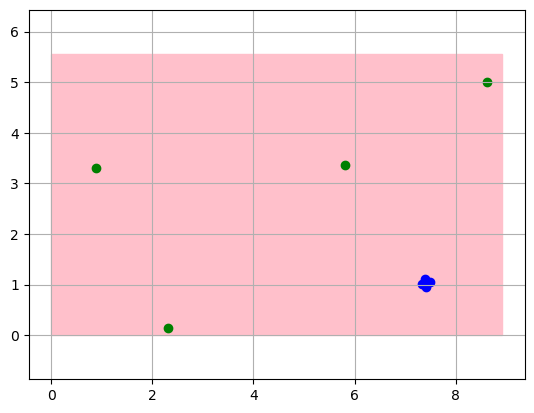

In [2]:
## 生成空间坐标
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpathes
class room_para:
    def __init__(self, n_sources):
        def mic_judge():
            center_room = self.wall / 2
            xy_delta = self.center_mic - center_room
            distance = np.sqrt(np.sum(xy_delta**2))
            if distance < 0.2:
                return False
            else:
                return True

        def source_judge():
            dis_mic = np.array([ np.sqrt(np.sum((self.loc_source[i] - self.center_mic)**2))
                       for i in range(n_sources)
                    ])
            dis_center = np.array([ np.sqrt(np.sum((self.loc_source[i] - self.wall / 2)**2))
                       for i in range(n_sources)
                    ])
            dis_source = np.array([ np.sqrt(np.sum((self.loc_source[i] - self.loc_source[j] )**2))
                           for i in range(n_sources)
                           for j in range(i+1, n_sources)])

            if np.min(dis_mic) > 1.5 and np.min(dis_center) > 0.2 and np.min(dis_source) > 1 :
                return True

        self.n_ch = n_sources
        self.T60 = 10 * random.randint(20, 60)
        self.fs = 16000

        self.wall = 5 + 5* np.array([random.random() , random.random()])
        self.upper = 3 + random.random()


        self.r_mic = 0.075 + 0.05 * random.random()
        self.z_mic = 1 + random.random()
        while True:
            self.center_mic = self.r_mic +  np.array([
                (self.wall[0] - 2* self.r_mic) * random.random() ,
                (self.wall[1] - 2* self.r_mic) * random.random()])
            if mic_judge():
                break
        self.theta_mic = (1 / n_sources) * np.arange(0 , n_sources) * 360 + random.randint(0, 360)
        self.loc_mic = self.r_mic * np.array( [
            np.cos(self.theta_mic * 2* np.pi / 360) ,
            np.sin(self.theta_mic * 2* np.pi / 360)]).T \
                       + self.center_mic

        self.z_source = 1.5 + 0.5 * np.random.rand(1, n_sources).squeeze()
        while True:
            self.loc_source = self.wall * np.random.rand(n_sources , 2)
            if source_judge():
                break

        self.xyz_source = np.hstack((self.loc_source, self.z_source[:, None]))
        self.xyz_mic = (np.hstack((self.loc_source, self.z_mic* np.ones((n_sources,1)))))
        self.xyz_box = np.hstack((self.wall, self.upper))


    def pic_show(self):
        fig,ax = plt.subplots()

        rect = mpathes.Rectangle([0,0], self.wall[0], self.wall[1], color = 'pink')
        ax.add_patch(rect)

        x_mic = self.loc_mic[:,0]
        y_mic = self.loc_mic[:,1]
        plt.scatter(x_mic, y_mic, c='blue', label = 'function')

        plt.scatter(self.loc_source[:,0], self.loc_source[:,1], c='green', label = 'function')


        plt.axis('equal')
        plt.grid()
        plt.show()

room = room_para(4)
print(room.xyz_box)
# print(room.xyz_mic)
# print(room.xyz_source)

room.pic_show()


In [3]:
# 房间生成样例

import pyroomacoustics as pra
# n_sources = 3

def simulate(n_sources = 2,draw = False):

    box = room_para(n_sources)
    # print(box.xyz_source)

    rt60 = box.T60 / 1000
    fs = box.fs
    n_ch = box.n_ch

    e_absorption , max_order = pra.inverse_sabine(rt60, box.xyz_box)
    echo_room = pra.ShoeBox(box.xyz_box, materials = pra.Material(e_absorption), max_order = max_order, fs = fs)

    echo_room.add_microphone_array(box.xyz_mic.T)
    for i in range(n_ch):
        echo_room.add_source(box.xyz_source[i,:].tolist())


    echo_room.compute_rir()

    if draw:
        fig, ax = echo_room.plot()
        ax.set_xlim([-1, 10])
        ax.set_ylim([-1, 10])
        ax.set_zlim([-1, 5])
        fig.show()


    ret = echo_room.rir

    len_ret = np.array([len(ret[i][j])
                        for i in range(n_sources)
                        for j in range(n_sources)])
    lr = np.min(len_ret)
    for i in range(n_sources):
        for j in range(n_sources):
            ret[i][j] = ret[i][j][:lr]

    ret2 = np.array(ret , dtype = float)

    return ret2


ret = simulate(4)
print(ret.shape[0])

4


In [4]:
# 以双通道为例, 信号目录的抽取最后要合并成一个class
# 算了，不合并了
import os
import random
import pandas as pd
import librosa

def get_sources(n_sources = 2):


    dataset_dir = r'C:\Users\aalab_linziyao\PycharmProjects\ilrma-t\WSJ_ilrma-t'

    speakers = os.listdir(dataset_dir)
    n_speaker = len(speakers)
    speaker_set = [os.listdir(os.path.join(dataset_dir, i))
        for i in speakers]


    speaker_value = random.sample(np.arange(n_speaker).tolist(), n_sources)
    # 此处将采用datafame数据格式整合数据

    # for i in range(10):
    #     print(len(speaker_set[i]))


    data = pd.DataFrame(speaker_set, speakers)
    # print(data)

    source_choosed = [
        data.loc[speakers[ i ]][random.randint(0,len(speaker_set[i])-1)]
        for i in speaker_value
        ]


    source_path = [
        os.path.join(dataset_dir,speakers[speaker_value[i]] , source_choosed[i])
                   for i in range(n_sources)
    ]
    # print(source_path)

    src0, _ = librosa.load(source_path[0], sr=16000)
    # print(src0.shape[0])

    sig = []
    sig_len = []
    for i in range(n_sources):
        src, _ = librosa.load(source_path[i], sr=16000)
        sig.append(src)
        sig_len.append(src.shape[0])
    # print(max(sig_len))
    sig_np = np.zeros((n_sources, max(sig_len)))
    for i in range(n_sources):
        sig_np[i, : sig_len[i]] = sig[i]
    # print(np.shape(sig_np))
    return sig_np

sig = get_sources(4)

In [5]:
# 混合这些信号——无噪声
from scipy.signal import convolve
import soundfile as sf
n_sources = 2
def get_mixed_sig(n_sources = 2):
    rir = simulate(n_sources = n_sources)
    sig = get_sources(n_sources = n_sources)

    sig_mixed = []
    for i in range(n_sources):
        a = convolve(sig[0] , rir[i][0])
        for j in range(1 , n_sources):
            a = a + convolve(sig[j] , rir[i][j])
        sig_mixed.append(a)

    sig_mixed = np.array(sig_mixed)
    # sf.write('mix_test.wav', sig_mixed[1], 16000)
    return sig_mixed

get_mixed_sig(n_sources)
# 输入：RIR，

array([[ 5.19830076e-18,  3.89872557e-18,  4.35357689e-17, ...,
        -1.82366950e-16,  1.86082923e-16,  1.30119966e-16],
       [-1.29957519e-17,  2.46919286e-17, -6.23796092e-17, ...,
         1.42953271e-17, -2.46919286e-17, -9.09702634e-18]])

In [12]:
# 导入一个IVA函数测试一下
import numpy as np
import pyroomacoustics as pra
from toolbox import projection_back
import soundfile as sf

n_sources = 2
sig_mixed = get_mixed_sig(n_sources, SNR= 30)
L_frame = 1024
hop = L_frame//4
win_a = pra.hann(L_frame)
win_s = pra.transform.stft.compute_synthesis_window(win_a, hop)

X = pra.transform.stft.analysis(sig_mixed.T, L_frame,  hop, win=win_a)
Y = pra.bss.auxiva(X, n_iter=30, proj_back=True)
y = pra.transform.stft.synthesis(Y, L_frame, hop, win=win_s)
print(np.shape(y))
sf.write('septest0.wav', y[:,0], 16000)
sf.write('septest1.wav', y[:,1], 16000)

(137728, 2)


In [11]:
# 重写上面信号混合算法，需要对信号的响度进行归一化处理，并且添加噪声
from scipy.signal import convolve
import soundfile as sf
n_sources = 2





def get_mixed_sig(n_sources = 2, SNR = 30):

    def add_noise(mixed_sig , SNR = 10):

        n_sources = mixed_sig.shape[0]
        len_f = mixed_sig.shape[1]

        pw_n = 10**(- SNR / 10) * n_sources

        noise_path = r'C:\Users\aalab_linziyao\PycharmProjects\ilrma-t\noise.wav'
        noise, _ = librosa.load(noise_path, sr=16000)
        noise = noise / np.var(noise)

        n_frames = noise.shape[0] // mixed_sig.shape[1]
        noise_frame = np.array([noise[i*len_f : (i+1)*len_f ]
            for i in range(n_frames)
        ])
        # noise_cs = random.sample(np.arange(n_frames).tolist(), n_sources)
        noise_cs = [1,1]
        noise_sig_add = pw_n * noise_frame[noise_cs, :]

        return noise_sig_add + mixed_sig


    rir = simulate(n_sources = n_sources)
    sig = get_sources(n_sources = n_sources)

    sig_mixed = []
    for i in range(n_sources):
        a = convolve(sig[0] , rir[i][0])
        for j in range(1 , n_sources):
            a = a + convolve(sig[j] , rir[i][j])
        sig_mixed.append(a)

    sig_mixed = np.array(sig_mixed)/np.var(sig_mixed[0])
    sig_mixed_n = add_noise(sig_mixed, SNR)


    # sf.write('mix_test.wav', sig_mixed[1], 16000)
    return sig_mixed_n

get_mixed_sig(n_sources)

array([[-0.07463079, -0.09622324, -0.12201252, ..., -0.09610158,
        -0.08229458, -0.08113894],
       [-0.07463079, -0.09622324, -0.12201252, ..., -0.09610158,
        -0.08229458, -0.08113894]])

In [47]:
random.sample(np.arange(4).tolist(), 2)


[1, 2]

综合考虑一下，觉得这个算法有些问题，暂时不考虑加入噪声，先写信号的评估模块
框架为，得到混合后的信号的时候计算SI-SIR,在分离后对信号进行裁剪并且再次计算

考虑到复杂性，以及多个算法联合对比的需要，此次算法采用先生成混合数据，并统一保存的策略
暂时不考虑加入噪声——直到那个傻逼作者回我邮件
SI-SIR标准在生成数据时一并计算
另外两个标准似乎不是求delta，那么就暂时不考虑了

In [18]:
# 关于如何匹配那个玩意

import pandas as pd
import re
import soundfile as sf

df = pd.read_excel(r'C:\Users\aalab_linziyao\PycharmProjects\ilrma-t\mixed\ch_3_test.xlsx')
a = df.loc[3][1]
a = a.replace('\\\\','\\')

nongre = re.compile('WSJ.*?wav')
c = nongre.matcher(a)
# c = re.findall(r"^WSJ  .wav$", b)
print(c[0])
sf.read(c[0])


AttributeError: 're.Pattern' object has no attribute 'matcher'

In [37]:
import pandas as pd
import numpy as np


df = pd.read_excel(r'C:\Users\aalab_linziyao\PycharmProjects\ilrma-t\mixed\ch_3.xlsx')
a = df.loc[3][2]
print(a)

# a = a.replace('[','')
# a = a.replace(']','')
a = a.strip('[]')
b = a.split(' ')
c = np.array([float(k)
for k in b])
c

[-15.91634427 -17.49322794 -21.14204906]


array([-15.91634427, -17.49322794, -21.14204906])

In [39]:
import pandas as pd
import numpy as np


df = pd.read_excel(r'C:\Users\aalab_linziyao\PycharmProjects\ilrma-t\mixed\ch_3.xlsx')
a = df.loc[3][2]
print(a)

a.strip('[]')

[-15.91634427 -17.49322794 -21.14204906]


'-15.91634427 -17.49322794 -21.14204906'